# Phân tích Hồi quy Tuyến tính Dự đoán Giá Bất động sản

## Mục tiêu
Xây dựng mô hình hồi quy tuyến tính để dự đoán giá bất động sản dựa trên các đặc tính như diện tích, số phòng, số toilet và các yếu tố pháp lý.

## Mô tả dữ liệu
- **ad_type_name**: Loại bất động sản
- **area**: Diện tích (m²)
- **price**: Giá bất động sản (VND)
- **address**: Địa chỉ
- **property_legal_document**: Giấy tờ pháp lý
- **rooms**: Số phòng
- **toilets**: Số toilet

In [424]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import traceback
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import scipy.stats as stats

In [425]:
# Đọc dữ liệu
df = pd.read_csv("BDS_cleaned.csv")

In [426]:
# Xem thông tin cơ bản
print(df.head())
print(df.shape)
print(df.info())
print(df.describe())

      ad_type_name  area        price address property_legal_document  rooms  \
0            Nhà ở    74   7800000000  Hà Nội                đã có sổ    3.0   
1  Căn hộ/Chung cư   129   6800000000  Hà Nội           sổ hồng riêng    3.0   
2  Căn hộ/Chung cư    77      4500000  Hà Nội           sổ hồng riêng    1.0   
3            Nhà ở    78  95000000000  Hà Nội                đã có sổ    8.0   
4  Căn hộ/Chung cư    78     11000000  Hà Nội             không có sổ    2.0   

   toilets  
0      4.0  
1      2.0  
2      1.0  
3      7.0  
4      1.0  
(2000, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ad_type_name             2000 non-null   object 
 1   area                     2000 non-null   int64  
 2   price                    2000 non-null   int64  
 3   address                  2000 non-null   object 
 

In [427]:
# Check null values
print(df.isnull().sum()*100/df.shape[0])

ad_type_name               0.0
area                       0.0
price                      0.0
address                    0.0
property_legal_document    0.0
rooms                      0.0
toilets                    0.0
dtype: float64


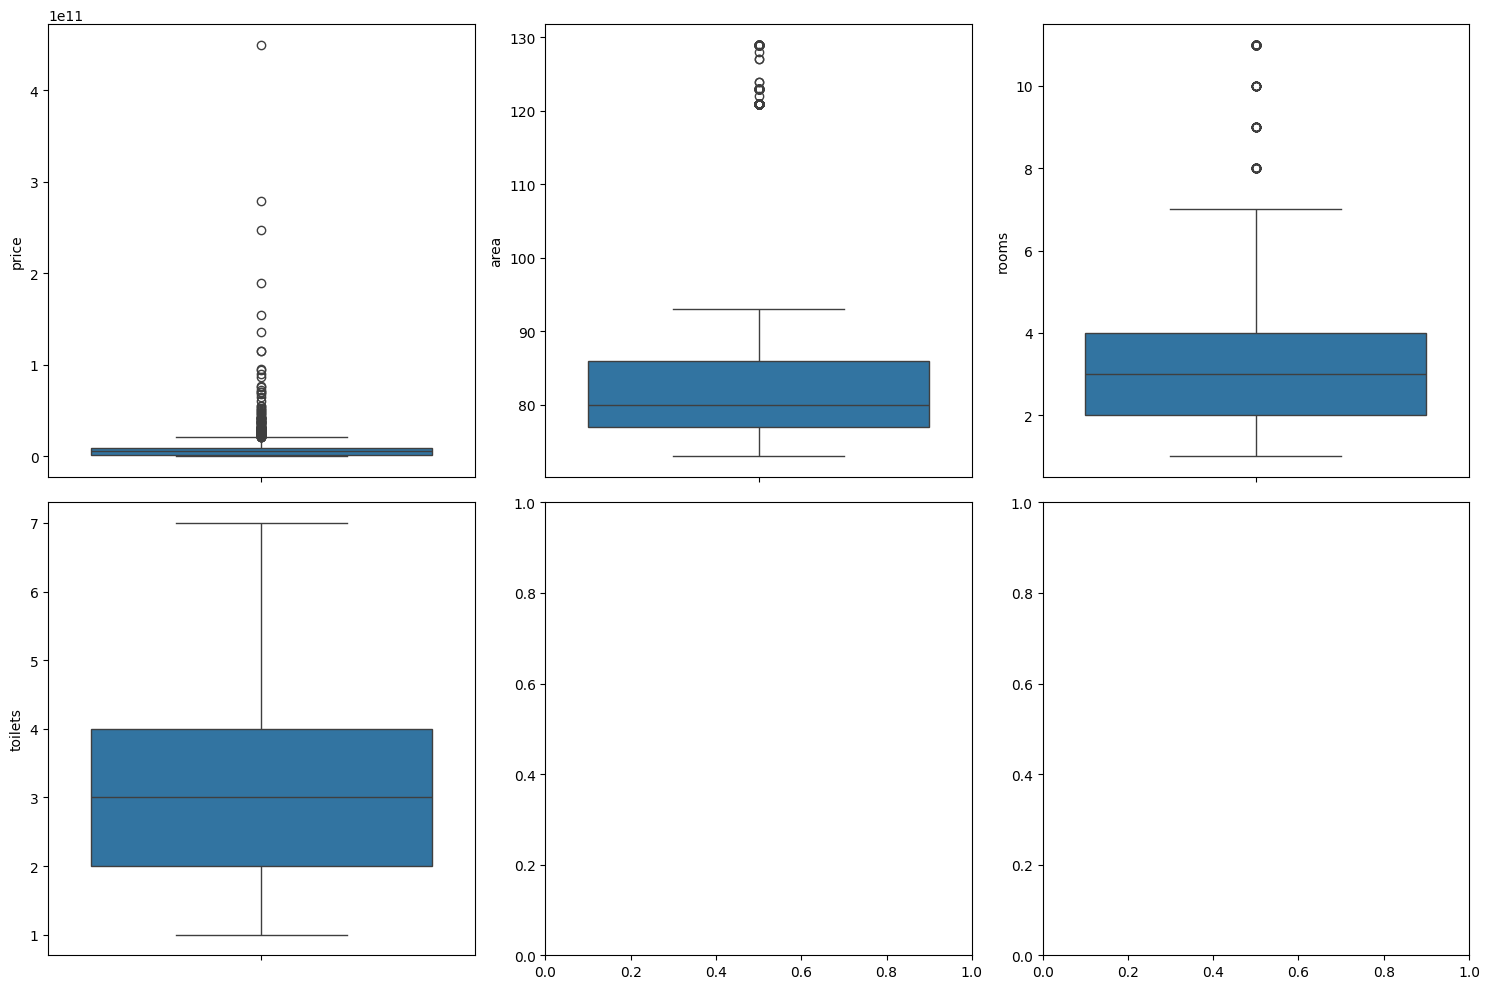

In [428]:
# Phân tích outliers cho các biến số
fig, axs = plt.subplots(2,3, figsize=(15,10))
sns.boxplot(df['price'], ax=axs[0,0])
sns.boxplot(df['area'], ax=axs[0,1])
sns.boxplot(df['rooms'], ax=axs[0,2])
sns.boxplot(df['toilets'], ax=axs[1,0])
plt.tight_layout()

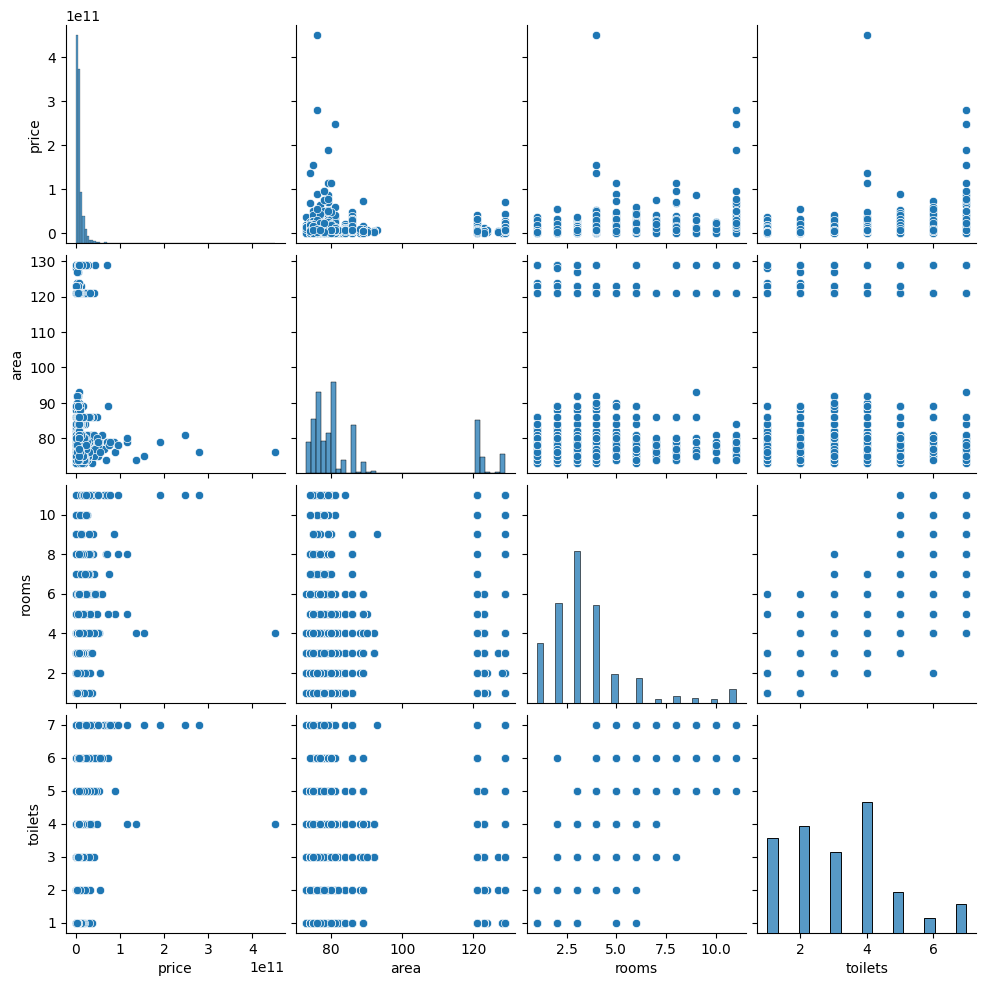

In [429]:
# Pairplot cho các biến số
sns.pairplot(df[['price', 'area', 'rooms', 'toilets']])
plt.show()

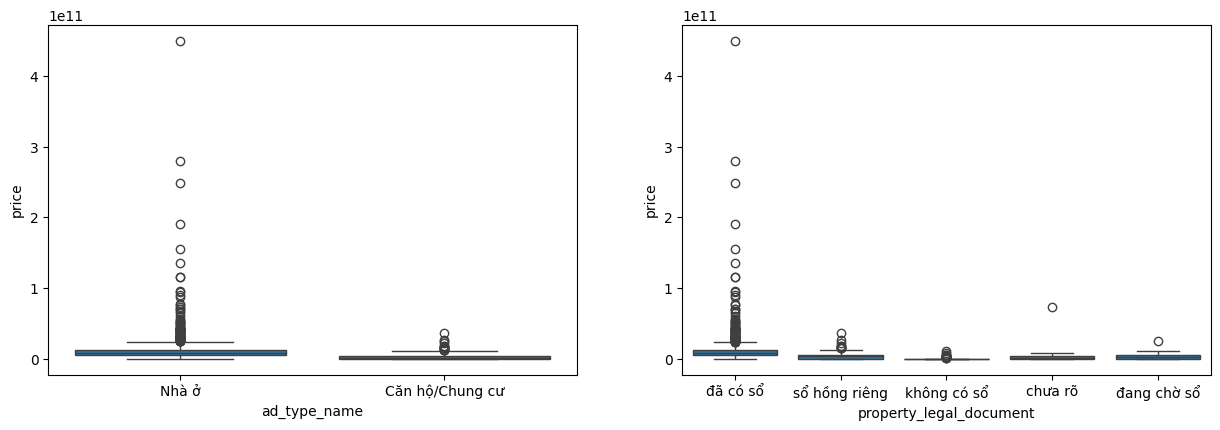

In [430]:
# Boxplot cho các biến phân loại
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.boxplot(x='ad_type_name', y='price', data=df)
plt.subplot(2,2,2)
sns.boxplot(x='property_legal_document', y='price', data=df)
plt.show()

In [431]:
# Chuyển đổi biến phân loại có 2 giá trị
varlist_binary = []  # Xác định các biến có 2 giá trị nếu có

def binary_map(x):
    return x.map({'có': 1, 'không': 0})  # Tuỳ chỉnh theo dữ liệu thực tế

In [432]:
# Tạo dummy variables cho biến có nhiều hơn 2 category
status = pd.get_dummies(df['property_legal_document'], drop_first=True)
df = pd.concat([df, status], axis=1)
df.drop(['property_legal_document'], axis=1, inplace=True)

In [433]:
# Tương tự cho ad_type_name
ad_type_dummies = pd.get_dummies(df['ad_type_name'], drop_first=True)
df = pd.concat([df, ad_type_dummies], axis=1)
df.drop(['ad_type_name'], axis=1, inplace=True)

In [434]:
np.random.seed(0)
df_train, df_test = train_test_split(df, train_size=0.7, test_size=0.3, random_state=100)

# Chuẩn hoá
scaler = MinMaxScaler()
num_vars = ['area', 'rooms', 'toilets', 'price']  # Thêm các biến số khác nếu có
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

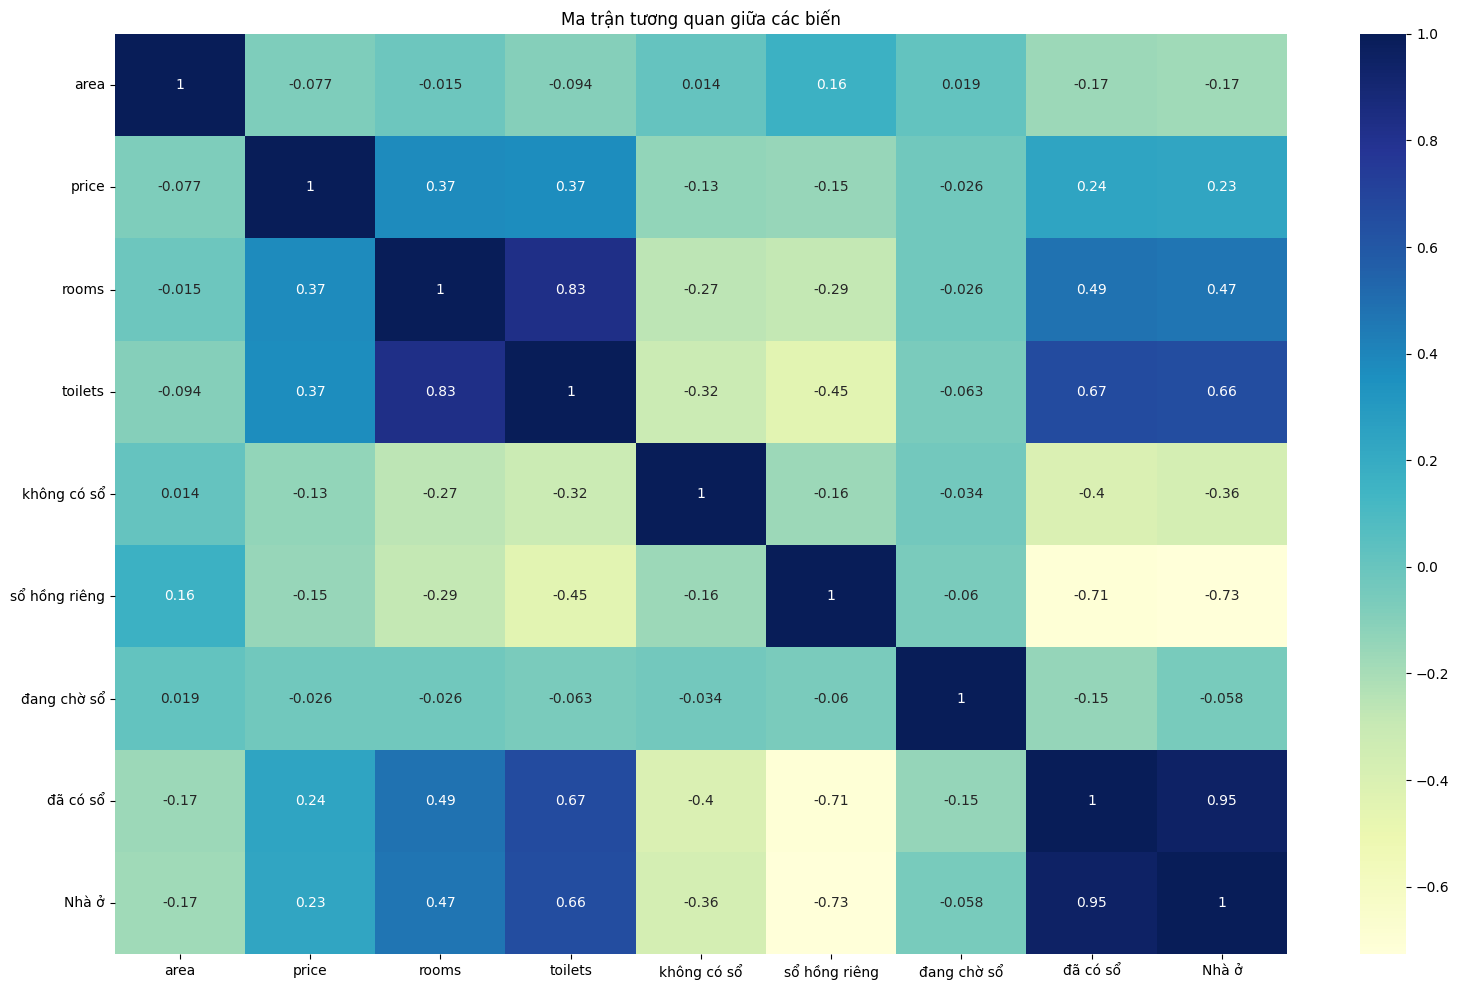

In [435]:
df_train_numeric = df_train.drop('address', axis=1)

plt.figure(figsize=(16,10))
sns.heatmap(df_train_numeric.corr(), annot=True, cmap="YlGnBu")
plt.title("Ma trận tương quan giữa các biến")
plt.tight_layout()
plt.show()

In [436]:
y_train = df_train.pop('price')

X_train = df_train.drop('address', axis=1)

for col in X_train.columns:
    print(f"- {col}: {X_train[col].dtype}")

- area: float64
- rooms: float64
- toilets: float64
- không có sổ: bool
- sổ hồng riêng: bool
- đang chờ sổ: bool
- đã có sổ: bool
- Nhà ở: bool


In [437]:
# Sử dụng RFE để chọn features
lm = LinearRegression()

In [438]:
# Xác định số lượng features muốn chọn
n_features_to_select = min(6, X_train.shape[1])  # Giảm xuống 6 để tránh overfitting

In [439]:
try:
    rfe = RFE(lm, n_features_to_select=n_features_to_select)
    rfe = rfe.fit(X_train, y_train)
    
    rfe_results = list(zip(X_train.columns, rfe.support_, rfe.ranking_))
    for feature, supported, ranking in rfe_results:
        status = "ĐƯỢC CHỌN" if supported else "KHÔNG ĐƯỢC CHỌN"
        print(f"{status} - {feature} (Ranking: {ranking})")
    
    selected_cols = X_train.columns[rfe.support_]
    print(f"\nCác features được chọn: {list(selected_cols)}")
    
    X_train_rfe = X_train[selected_cols]
    print(f"Kích thước X_train_rfe: {X_train_rfe.shape}")

except Exception as e:
    selected_cols = X_train.columns
    X_train_rfe = X_train

ĐƯỢC CHỌN - area (Ranking: 1)
ĐƯỢC CHỌN - rooms (Ranking: 1)
ĐƯỢC CHỌN - toilets (Ranking: 1)
ĐƯỢC CHỌN - không có sổ (Ranking: 1)
ĐƯỢC CHỌN - sổ hồng riêng (Ranking: 1)
ĐƯỢC CHỌN - đang chờ sổ (Ranking: 1)
KHÔNG ĐƯỢC CHỌN - đã có sổ (Ranking: 3)
KHÔNG ĐƯỢC CHỌN - Nhà ở (Ranking: 2)

Các features được chọn: ['area', 'rooms', 'toilets', 'không có sổ', 'sổ hồng riêng', 'đang chờ sổ']
Kích thước X_train_rfe: (1400, 6)


In [440]:
X_train_rfe = X_train_rfe.astype(float)
y_train = y_train.astype(float)
X_train_rfe_sm = sm.add_constant(X_train_rfe)

In [441]:
try:
    lm_sm = sm.OLS(y_train, X_train_rfe_sm).fit()
    
    vif = pd.DataFrame()
    vif['Features'] = X_train_rfe_sm.columns
    vif['VIF'] = [variance_inflation_factor(X_train_rfe_sm.values, i) for i in range(X_train_rfe_sm.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by="VIF", ascending=False)
    
    print(vif)
    
    y_train_pred = lm_sm.predict(X_train_rfe_sm)
    residuals = y_train - y_train_pred

    
    
    mse = mean_squared_error(y_train, y_train_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_train, y_train_pred)
    r2 = r2_score(y_train, y_train_pred)
    
    print(f"\nCHỈ SỐ ĐÁNH GIÁ MÔ HÌNH:")
    print(f"R-squared (R²): {r2:.4f}")
    print(f"R-squared điều chỉnh: {lm_sm.rsquared_adj:.4f}")
    print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
    print(f"MAE (Mean Absolute Error): {mae:.4f}")
    

except Exception as e:
    print(traceback.format_exc())

        Features   VIF
0          const  6.59
3        toilets  4.29
2          rooms  3.36
5  sổ hồng riêng  1.53
4    không có sổ  1.30
1           area  1.04
6    đang chờ sổ  1.03

CHỈ SỐ ĐÁNH GIÁ MÔ HÌNH:
R-squared (R²): 0.1547
R-squared điều chỉnh: 0.1511
RMSE (Root Mean Squared Error): 0.0390
MAE (Mean Absolute Error): 0.0128


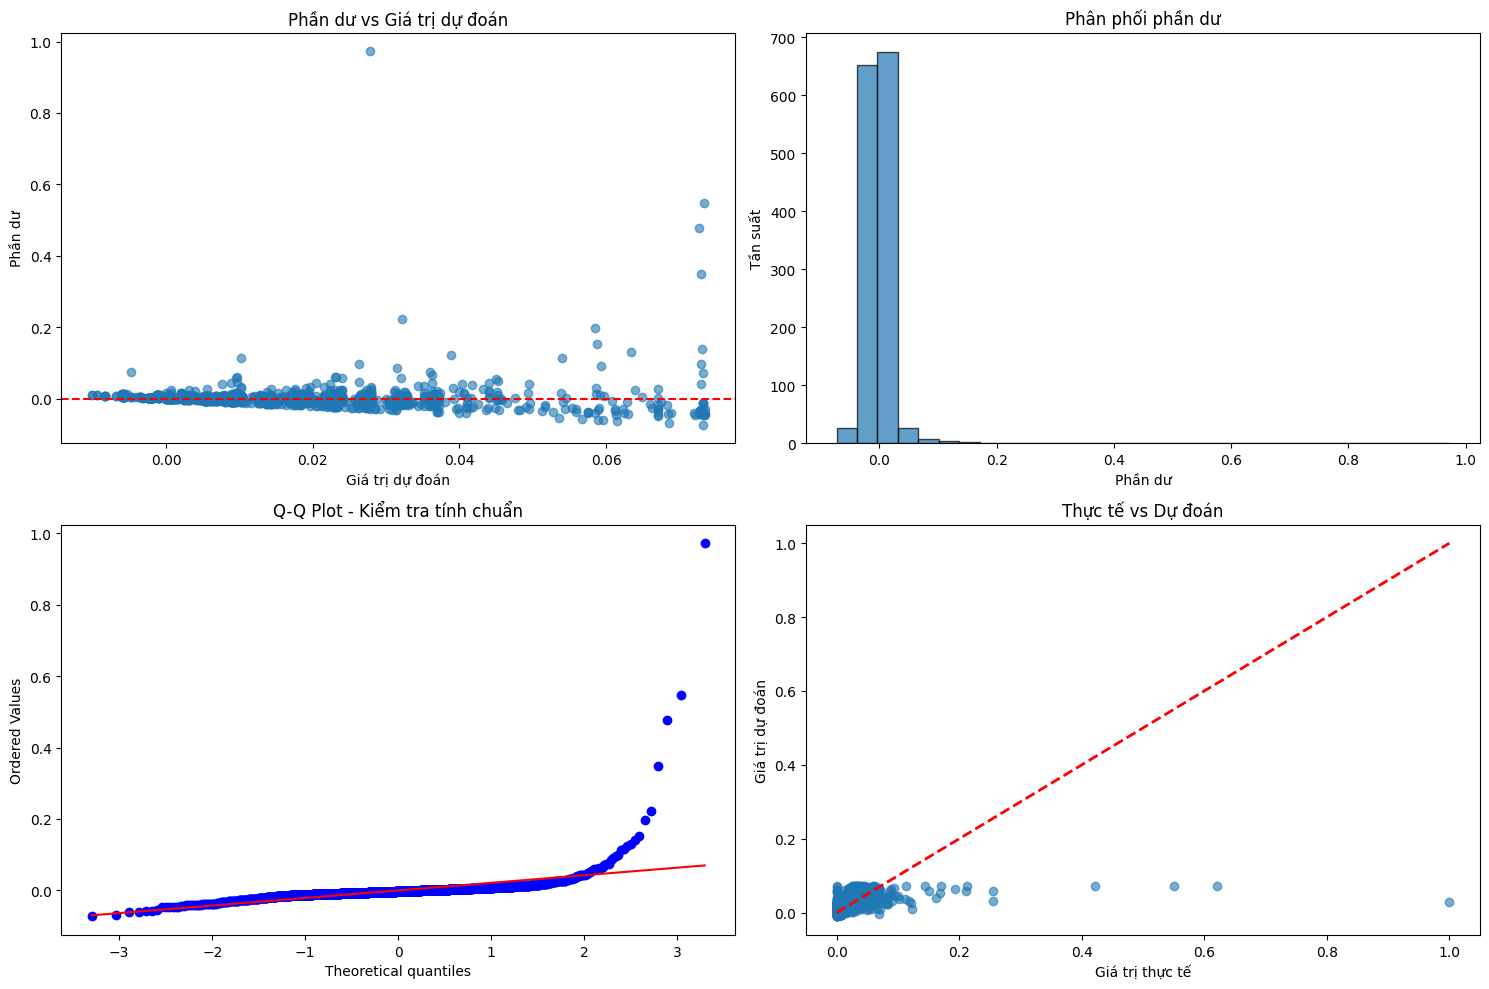

In [442]:
# Vẽ biểu đồ phần dư
plt.figure(figsize=(15, 10))
    
# Biểu đồ 1: Phần dư so với giá trị dự đoán
plt.subplot(2, 2, 1)
plt.scatter(y_train_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Giá trị dự đoán')
plt.ylabel('Phần dư')
plt.title('Phần dư vs Giá trị dự đoán')
    
# Biểu đồ 2: Phân phối phần dư
plt.subplot(2, 2, 2)
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Phần dư')
plt.ylabel('Tần suất')
plt.title('Phân phối phần dư')
    
# Biểu đồ 3: Q-Q plot
plt.subplot(2, 2, 3)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot - Kiểm tra tính chuẩn')
    
# Biểu đồ 4: Giá trị thực tế vs giá trị dự đoán
plt.subplot(2, 2, 4)
plt.scatter(y_train, y_train_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Giá trị thực tế')
plt.ylabel('Giá trị dự đoán')
plt.title('Thực tế vs Dự đoán')
    
plt.tight_layout()
plt.show()

In [443]:
    # Đánh giá ý nghĩa thống kê của các biến
print(f"\nĐÁNH GIÁ Ý NGHĨA THỐNG KÊ CỦA CÁC BIẾN:")
significant_vars = []
for feature in selected_cols:
    pvalue = lm_sm.pvalues[feature]
    significance = "CÓ Ý NGHĨA" if pvalue < 0.05 else "KHÔNG CÓ Ý NGHĨA"
    print(f"{significance}: {feature} (p-value: {pvalue:.4f})")
    if pvalue < 0.05:
        significant_vars.append(feature)
    
print(f"\nSố biến có ý nghĩa thống kê (p < 0.05): {len(significant_vars)}/{len(selected_cols)}")


ĐÁNH GIÁ Ý NGHĨA THỐNG KÊ CỦA CÁC BIẾN:
CÓ Ý NGHĨA: area (p-value: 0.0233)
CÓ Ý NGHĨA: rooms (p-value: 0.0000)
CÓ Ý NGHĨA: toilets (p-value: 0.0022)
KHÔNG CÓ Ý NGHĨA: không có sổ (p-value: 0.4157)
KHÔNG CÓ Ý NGHĨA: sổ hồng riêng (p-value: 0.7886)
KHÔNG CÓ Ý NGHĨA: đang chờ sổ (p-value: 0.6675)

Số biến có ý nghĩa thống kê (p < 0.05): 3/6
